In [14]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load Data.

In [16]:
print("Loading data...")
df = pd.read_csv('recs2020_public_v7.csv')  
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Loading data...
Dataset shape: (18496, 799)

First few rows:
    DOEID    REGIONC            DIVISION  STATE_FIPS state_postal  \
0  100001       WEST      Mountain South          35           NM   
1  100002      SOUTH  West South Central           5           AR   
2  100003       WEST      Mountain South          35           NM   
3  100004      SOUTH      South Atlantic          45           SC   
4  100005  NORTHEAST     Middle Atlantic          34           NJ   

       state_name   BA_climate IECC_climate_code UATYP10  HDD65  ...  \
0      New Mexico    Mixed-Dry                4B       U   3844  ...   
1        Arkansas  Mixed-Humid                4A       U   3766  ...   
2      New Mexico    Mixed-Dry                4B       U   3819  ...   
3  South Carolina  Mixed-Humid                3A       U   2614  ...   
4      New Jersey  Mixed-Humid                4A       U   4219  ...   

   EVCHRGHOME  EVCHRGAPT  EVCHRGWKS  EVCHRGBUS  EVCHRGMUNI  EVCHRGDLR  \
0        -2.0     

Feature Selection

In [17]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Define feature groups
size_features = ['TOTSQFT_EN', 'TOTHSQFT', 'TOTCSQFT']
weather_features = ['HDD65', 'CDD65']
climate_features = ['BA_climate', 'IECC_climate_code']
solar_features = ['SOLAR', 'USESOLAR', 'SOLWATER']

# Building type/use features
building_type_features = ['TYPEHUQ', 'STORIES', 'KOWNRENT']

# Heating equipment features
heating_features = ['EQUIPM', 'FUELHEAT', 'EQUIPAGE', 'EQUIPAUXTYPE', 'EQUIPAUX']

# Cooling equipment features
cooling_features = ['AIRCOND', 'ACEQUIPM_PUB', 'ACEQUIPAGE', 'ACEQUIPAUXTYPE_PUB',
                   'NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC']

# Water heating features
water_heat_features = ['WHEATAGE', 'WHEATSIZ', 'WHEATBKT', 'FUELH2O']

# Appliance age features (for plug loads)
appliance_features = ['AGERFRI1', 'AGEFRZR', 'AGECDRYER', 'AGECWASH']

# Occupancy/usage features
occupancy_features = ['NHSLDMEM', 'ATHOME', 'ZATHOME', 'TELLWORK', 'TELLDAYS',
                     'NUMCHILD', 'NUMADULT1', 'NUMADULT2']

# Building characteristics
building_char_features = ['YEARMADERANGE']

# Insulation features
insulation_features = ['ADQINSUL', 'ATTIC', 'ATTICFIN', 'ATTICFAN', 
                      'BASEFIN', 'TREESHAD']

# Window features
window_features = ['TYPEGLASS', 'WINFRAME', 'ORIGWIN', 'WINDOWS']

# Define target variable
TARGET = 'TOTALBTU'  # Total annual site energy consumption (BTU)

# Combine all feature groups
all_features = (size_features + weather_features + climate_features + solar_features +
                building_type_features + heating_features + cooling_features + 
                water_heat_features + appliance_features + occupancy_features + 
                building_char_features + insulation_features + window_features)

# Check which features exist in the dataset
available_features = [f for f in all_features if f in df.columns]
missing_features = [f for f in all_features if f not in df.columns]

print(f"\nAvailable features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"Missing features ({len(missing_features)}): {missing_features}")

# Identify categorical features
categorical_features = []

# Climate features (already identified)
categorical_features.extend([f for f in climate_features if f in available_features])

# Building type features (categorical)
categorical_features.extend([f for f in building_type_features if f in available_features])

# Equipment type features (categorical)
equipment_categorical = ['EQUIPM', 'FUELHEAT', 'EQUIPAUXTYPE', 'EQUIPAUX',
                        'ACEQUIPM_PUB', 'ACEQUIPAUXTYPE_PUB', 'FUELH2O']
categorical_features.extend([f for f in equipment_categorical if f in available_features])

# Usage pattern features (categorical/ordinal)
usage_categorical = ['ATHOME', 'ZATHOME', 'TELLWORK']
categorical_features.extend([f for f in usage_categorical if f in available_features])

# Building characteristics (categorical)
categorical_features.extend([f for f in building_char_features if f in available_features])

# Insulation/window features (categorical/ordinal)
building_categorical = ['ADQINSUL', 'ATTIC', 'ATTICFIN', 'ATTICFAN', 'BASEFIN',
                       'TYPEGLASS', 'WINFRAME', 'ORIGWIN']
categorical_features.extend([f for f in building_categorical if f in available_features])

# Remove duplicates
categorical_features = list(set(categorical_features))

print(f"\nCategorical features: {categorical_features}")




FEATURE ENGINEERING

Available features (52): ['TOTSQFT_EN', 'TOTHSQFT', 'TOTCSQFT', 'HDD65', 'CDD65', 'BA_climate', 'IECC_climate_code', 'SOLAR', 'USESOLAR', 'SOLWATER', 'TYPEHUQ', 'STORIES', 'KOWNRENT', 'EQUIPM', 'FUELHEAT', 'EQUIPAGE', 'EQUIPAUXTYPE', 'EQUIPAUX', 'AIRCOND', 'ACEQUIPM_PUB', 'ACEQUIPAGE', 'ACEQUIPAUXTYPE_PUB', 'NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC', 'WHEATAGE', 'WHEATSIZ', 'WHEATBKT', 'FUELH2O', 'AGERFRI1', 'AGEFRZR', 'AGECDRYER', 'AGECWASH', 'NHSLDMEM', 'ATHOME', 'ZATHOME', 'TELLWORK', 'TELLDAYS', 'NUMCHILD', 'NUMADULT1', 'NUMADULT2', 'YEARMADERANGE', 'ADQINSUL', 'ATTIC', 'ATTICFIN', 'ATTICFAN', 'BASEFIN', 'TREESHAD', 'TYPEGLASS', 'WINFRAME', 'ORIGWIN', 'WINDOWS']

Categorical features: ['STORIES', 'FUELH2O', 'TYPEGLASS', 'BA_climate', 'YEARMADERANGE', 'WINFRAME', 'ATTICFIN', 'ADQINSUL', 'ACEQUIPM_PUB', 'TYPEHUQ', 'EQUIPM', 'ORIGWIN', 'ATHOME', 'ATTICFAN', 'TELLWORK', 'IECC_climate_code', 'ATTIC', 'EQUIPAUXTYPE', 'ACEQUIPAUXTYPE_PUB', 'BASEFIN', 'ZATHOME', 'FUELHEAT', 

Data Preporcessing

In [18]:
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Create a copy for preprocessing
df_processed = df[available_features].copy()

# Add your target variable here - replace 'ENERGY_CONSUMPTION' with actual column name
# TARGET = 'ENERGY_CONSUMPTION'  # <-- REPLACE THIS
# If you need to calculate energy consumption from multiple columns, do it here
# For example: df_processed['energy_total'] = df['electricity'] + df['gas']

# Handle missing values
print("\nMissing values before imputation:")
print(df_processed.isnull().sum())

# Impute numerical features with median
numerical_features = [f for f in available_features if f not in categorical_features]
for col in numerical_features:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Impute categorical features with mode
for col in categorical_features:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("\nMissing values after imputation:")
print(df_processed.isnull().sum())

# Feature engineering: create derived features
if 'TOTHSQFT' in df_processed.columns and 'TOTCSQFT' in df_processed.columns:
    df_processed['heating_cooling_ratio'] = (
        df_processed['TOTHSQFT'] / (df_processed['TOTCSQFT'] + 1)
    )

if 'HDD65' in df_processed.columns and 'CDD65' in df_processed.columns:
    df_processed['total_degree_days'] = df_processed['HDD65'] + df_processed['CDD65']
    df_processed['heating_cooling_balance'] = (
        df_processed['HDD65'] / (df_processed['CDD65'] + 1)
    )

# Occupant density (people per square foot)
if 'NHSLDMEM' in df_processed.columns and 'TOTSQFT_EN' in df_processed.columns:
    df_processed['occupant_density'] = (
        df_processed['NHSLDMEM'] / (df_processed['TOTSQFT_EN'] + 1)
    )

# Total cooling equipment count
cooling_equipment_cols = ['NUMDLHPAC', 'NUMWWAC', 'NUMPORTAC']
cooling_cols_present = [c for c in cooling_equipment_cols if c in df_processed.columns]
if cooling_cols_present:
    df_processed['total_cooling_units'] = df_processed[cooling_cols_present].sum(axis=1)

# Average equipment age (if multiple age columns available)
age_cols = ['EQUIPAGE', 'ACEQUIPAGE', 'WHEATAGE']
age_cols_present = [c for c in age_cols if c in df_processed.columns]
if len(age_cols_present) >= 2:
    df_processed['avg_equipment_age'] = df_processed[age_cols_present].mean(axis=1)

# Total household members
household_cols = ['NUMCHILD', 'NUMADULT1', 'NUMADULT2']
household_cols_present = [c for c in household_cols if c in df_processed.columns]
if household_cols_present and 'NHSLDMEM' not in df_processed.columns:
    df_processed['total_household'] = df_processed[household_cols_present].sum(axis=1)

# Update feature lists
numerical_features = [f for f in df_processed.columns if f not in categorical_features]
all_features_processed = list(df_processed.columns)

print(f"\nFinal feature count: {len(all_features_processed)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")



DATA PREPROCESSING

Missing values before imputation:
TOTSQFT_EN            0
TOTHSQFT              0
TOTCSQFT              0
HDD65                 0
CDD65                 0
BA_climate            0
IECC_climate_code     0
SOLAR                 0
USESOLAR              0
SOLWATER              0
TYPEHUQ               0
STORIES               0
KOWNRENT              0
EQUIPM                0
FUELHEAT              0
EQUIPAGE              0
EQUIPAUXTYPE          0
EQUIPAUX              0
AIRCOND               0
ACEQUIPM_PUB          0
ACEQUIPAGE            0
ACEQUIPAUXTYPE_PUB    0
NUMDLHPAC             0
NUMWWAC               0
NUMPORTAC             0
WHEATAGE              0
WHEATSIZ              0
WHEATBKT              0
FUELH2O               0
AGERFRI1              0
AGEFRZR               0
AGECDRYER             0
AGECWASH              0
NHSLDMEM              0
ATHOME                0
ZATHOME               0
TELLWORK              0
TELLDAYS              0
NUMCHILD              0
NUMADULT1

PREPARE TARGET AND FEATURES

In [19]:
if TARGET not in df.columns:
    raise ValueError(f"Target variable '{TARGET}' not found in dataset! Available columns: {df.columns.tolist()}")

# Remove any rows where target is missing or invalid
valid_idx = df[TARGET].notna() & (df[TARGET] > 0)
print(f"\nFiltering data: {valid_idx.sum()} valid samples out of {len(df)} total")
print(f"Removed {(~valid_idx).sum()} samples with missing or zero energy consumption")

df = df[valid_idx].reset_index(drop=True)
df_processed = df_processed[valid_idx].reset_index(drop=True)

X = df_processed
y = df[TARGET]

print(f"\nTarget variable: {TARGET} (Total Annual Site Energy Consumption in BTU)")
print(f"Target statistics:\n{y.describe()}")
print(f"Target range: {y.min():,.0f} to {y.max():,.0f} BTU")





Filtering data: 18496 valid samples out of 18496 total
Removed 0 samples with missing or zero energy consumption

Target variable: TOTALBTU (Total Annual Site Energy Consumption in BTU)
Target statistics:
count    1.849600e+04
mean     8.300229e+04
std      5.320599e+04
min      1.182220e+03
25%      4.556516e+04
50%      7.418011e+04
75%      1.085350e+05
max      1.367548e+06
Name: TOTALBTU, dtype: float64
Target range: 1,182 to 1,367,548 BTU


TRAIN-TEST SPLIT

In [20]:
print("\n" + "="*70)
print("TRAIN-TEST SPLIT (90/10)")
print("="*70)

# Create bins for stratification (to handle continuous target)
n_bins = 10
y_binned = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.10, 
    random_state=RANDOM_STATE,
    stratify=y_binned
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set energy range: {y_train.min():,.0f} to {y_train.max():,.0f} BTU")
print(f"Test set energy range: {y_test.min():,.0f} to {y_test.max():,.0f} BTU")


TRAIN-TEST SPLIT (90/10)
Training set size: 16646 samples
Test set size: 1850 samples
Training set energy range: 1,182 to 1,367,548 BTU
Test set energy range: 4,821 to 400,076 BTU


Stratifies 5 fold Cross_Validation.

In [23]:
print("\n" + "="*70)
print("STRATIFIED 5-FOLD CROSS-VALIDATION")
print("="*70)

# Create stratified folds
n_folds = 5
y_train_binned = pd.qcut(y_train, q=n_bins, labels=False, duplicates='drop')
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Store CV results
cv_scores = {
    'fold': [],
    'mae': [],
    'rmse': [],
    'r2': []
}

# CatBoost parameters - optimized for residential energy prediction
catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 5,
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'random_seed': RANDOM_STATE,
    'verbose': False,
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 1
    # Note: Bayesian bootstrap doesn't use 'subsample' parameter
}

print("\nCatBoost Parameters:")
for key, value in catboost_params.items():
    print(f"  {key}: {value}")

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_binned), 1):
    print(f"\nTraining Fold {fold}/{n_folds}...")
    
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Create CatBoost pools
    train_pool = Pool(
        X_fold_train, 
        y_fold_train,
        cat_features=categorical_features
    )
    val_pool = Pool(
        X_fold_val, 
        y_fold_val,
        cat_features=categorical_features
    )
    
    # Train model
    model = CatBoostRegressor(**catboost_params)
    model.fit(train_pool, eval_set=val_pool, plot=False)
    
    # Predict on validation set
    y_pred = model.predict(X_fold_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_fold_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    r2 = r2_score(y_fold_val, y_pred)
    
    cv_scores['fold'].append(fold)
    cv_scores['mae'].append(mae)
    cv_scores['rmse'].append(rmse)
    cv_scores['r2'].append(r2)
    
    print(f"  MAE: {mae:,.0f} BTU")
    print(f"  RMSE: {rmse:,.0f} BTU")
    print(f"  R²: {r2:.4f}")

# Display CV results
cv_results = pd.DataFrame(cv_scores)
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS")
print("="*70)
print(cv_results)
print("\nAverage Scores:")
print(f"  MAE:  {cv_results['mae'].mean():,.0f} ± {cv_results['mae'].std():,.0f} BTU")
print(f"  RMSE: {cv_results['rmse'].mean():,.0f} ± {cv_results['rmse'].std():,.0f} BTU")
print(f"  R²:   {cv_results['r2'].mean():.4f} ± {cv_results['r2'].std():.4f}")


STRATIFIED 5-FOLD CROSS-VALIDATION

CatBoost Parameters:
  iterations: 1500
  learning_rate: 0.03
  depth: 8
  l2_leaf_reg: 5
  loss_function: RMSE
  eval_metric: MAE
  random_seed: 42
  verbose: False
  early_stopping_rounds: 100
  use_best_model: True
  bootstrap_type: Bayesian
  bagging_temperature: 1

Training Fold 1/5...
  MAE: 20,419 BTU
  RMSE: 32,537 BTU
  R²: 0.6402

Training Fold 2/5...
  MAE: 20,616 BTU
  RMSE: 31,844 BTU
  R²: 0.6337

Training Fold 3/5...
  MAE: 20,584 BTU
  RMSE: 31,115 BTU
  R²: 0.6453

Training Fold 4/5...
  MAE: 20,612 BTU
  RMSE: 34,682 BTU
  R²: 0.6016

Training Fold 5/5...
  MAE: 20,514 BTU
  RMSE: 33,362 BTU
  R²: 0.6054

CROSS-VALIDATION RESULTS
   fold           mae          rmse        r2
0     1  20419.146393  32537.420771  0.640155
1     2  20616.091515  31844.450923  0.633691
2     3  20584.109729  31115.438442  0.645261
3     4  20612.416814  34682.193306  0.601617
4     5  20514.439388  33361.640789  0.605429

Average Scores:
  MAE:  20,549

TRAINING FINAL MODEL

In [24]:
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

final_model = CatBoostRegressor(**catboost_params)
final_model.fit(train_pool, eval_set=test_pool, plot=False)


TRAINING FINAL MODEL


TEST SET EVALUATION

In [25]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

y_pred_test = final_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test MAE:  {test_mae:,.0f} BTU")
print(f"Test RMSE: {test_rmse:,.0f} BTU")
print(f"Test R²:   {test_r2:.4f}")

# Calculate MAPE (Mean Absolute Percentage Error) for interpretability
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"Test MAPE: {mape:.2f}%")


TEST SET EVALUATION
Test MAE:  20,525 BTU
Test RMSE: 30,637 BTU
Test R²:   0.6394
Test MAPE: 31.21%


FEATURE IMPORTANCE

In [26]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


FEATURE IMPORTANCE

Top 10 Most Important Features:
              feature  importance
14           FUELHEAT   15.286838
1            TOTHSQFT    9.384993
51            WINDOWS    6.809466
0          TOTSQFT_EN    6.388877
53  total_degree_days    4.960341
2            TOTCSQFT    4.067338
33           NHSLDMEM    3.530263
28            FUELH2O    3.526027
41      YEARMADERANGE    3.462182
3               HDD65    3.140497


See the resutls.


GENERATING VISUALIZATIONS


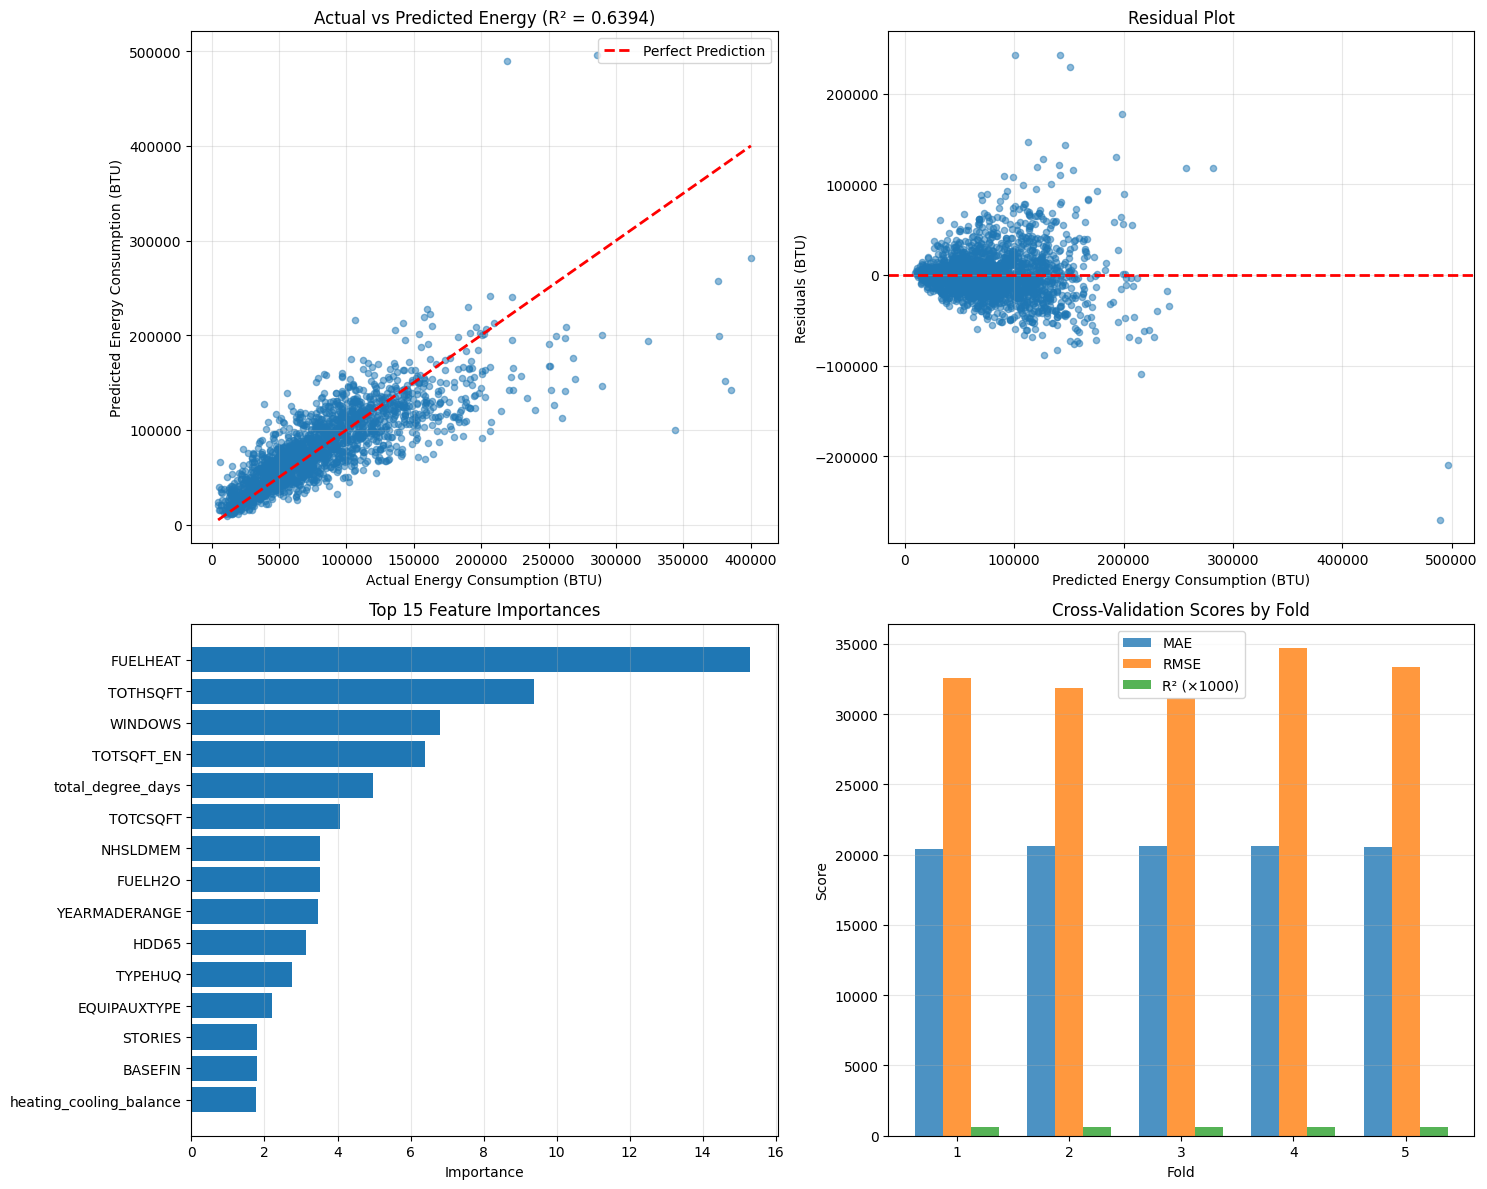


Visualization saved as 'catboost_results.png'

SAVING MODEL
Model saved as 'building_energy_catboost_model.cbm'
Feature importance saved as 'feature_importance.csv'

MODEL SUMMARY
Total samples: 18496
Training samples: 16646
Test samples: 1850
Number of features: 58
Categorical features: 24

Cross-Validation Performance:
  MAE:  20,549 ± 83 BTU
  RMSE: 32,708 ± 1,382 BTU
  R²:   0.6252 ± 0.0203

Test Set Performance:
  MAE:  20,525 BTU
  RMSE: 30,637 BTU
  R²:   0.6394
  MAPE: 31.21%

DONE!


In [27]:
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Energy Consumption (BTU)')
axes[0, 0].set_ylabel('Predicted Energy Consumption (BTU)')
axes[0, 0].set_title(f'Actual vs Predicted Energy (R² = {test_r2:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].ticklabel_format(style='plain', axis='both')

# Plot 2: Residuals
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Energy Consumption (BTU)')
axes[0, 1].set_ylabel('Residuals (BTU)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].ticklabel_format(style='plain', axis='both')

# Plot 3: Feature Importance (Top 15)
top_n = min(15, len(feature_importance))
feature_importance_top = feature_importance.head(top_n)
axes[1, 0].barh(range(top_n), feature_importance_top['importance'])
axes[1, 0].set_yticks(range(top_n))
axes[1, 0].set_yticklabels(feature_importance_top['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title(f'Top {top_n} Feature Importances')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: CV Scores
x_pos = np.arange(len(cv_results))
width = 0.25
axes[1, 1].bar(x_pos - width, cv_results['mae'], width, label='MAE', alpha=0.8)
axes[1, 1].bar(x_pos, cv_results['rmse'], width, label='RMSE', alpha=0.8)
axes[1, 1].bar(x_pos + width, cv_results['r2']*1000, width, label='R² (×1000)', alpha=0.8)
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Cross-Validation Scores by Fold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(cv_results['fold'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('catboost_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'catboost_results.png'")

# ============================================================================
# 11. SAVE MODEL
# ============================================================================
print("\n" + "="*70)
print("SAVING MODEL")
print("="*70)

model_filename = 'building_energy_catboost_model.cbm'
final_model.save_model(model_filename)
print(f"Model saved as '{model_filename}'")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("Feature importance saved as 'feature_importance.csv'")

# ============================================================================
# 12. MODEL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {len(all_features_processed)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"\nCross-Validation Performance:")
print(f"  MAE:  {cv_results['mae'].mean():,.0f} ± {cv_results['mae'].std():,.0f} BTU")
print(f"  RMSE: {cv_results['rmse'].mean():,.0f} ± {cv_results['rmse'].std():,.0f} BTU")
print(f"  R²:   {cv_results['r2'].mean():.4f} ± {cv_results['r2'].std():.4f}")
print(f"\nTest Set Performance:")
print(f"  MAE:  {test_mae:,.0f} BTU")
print(f"  RMSE: {test_rmse:,.0f} BTU")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {mape:.2f}%")
print("\n" + "="*70)
print("DONE!")
print("="*70)